In [7]:
import sys
import os
sys.path.append(os.path.abspath("..")) 

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import scipy.signal as signal

from pySNA import *

#(+180) Δ10
file_path1 = "(K_buffer_D91N_180mV_9T_C_30T)20250814211151.dat"
#(+160) Δ10
file_path2 = "(K_buffer_D91N_160mV_9T_C_30T)20250814211615.dat"
#(+140) Δ10
file_path3 = "(K_buffer_D91N_140mV_9T_C_30T)20250814212030.dat"
#(+120) Δ10
file_path4 = "(K_buffer_D91N_120mV_9T_C_30T)20250814213905.dat"
#(+100) Δ10
file_path5 = "(K_buffer_D91N_100mV_9T_C_30T)20250814213311.dat"

In [8]:
baseline = 256e-12 #加/减去offset之后的baseline
var = 2e-12
offset= -3e-12
threshold = baseline*0.5
pySNA = PySNA(baseline=baseline, var=var, threshold=threshold)
# 加载数据
pySNA.load(file_path1, output_samplerate=10000., lp_filter_cutoff=2500.)
pySNA.data = pySNA.data+offset

2026-02-17 03:20:48,519 - INFO - Successfully loaded .dat file: (K_buffer_D91N_180mV_9T_C_30T)20250814211151.dat
2026-02-17 03:20:48,563 - INFO - Data filtered with LP filter cutoff: 2500.0 Hz
2026-02-17 03:20:48,606 - INFO - Baseline = 42.77 pA, RMS = 70.61 pA


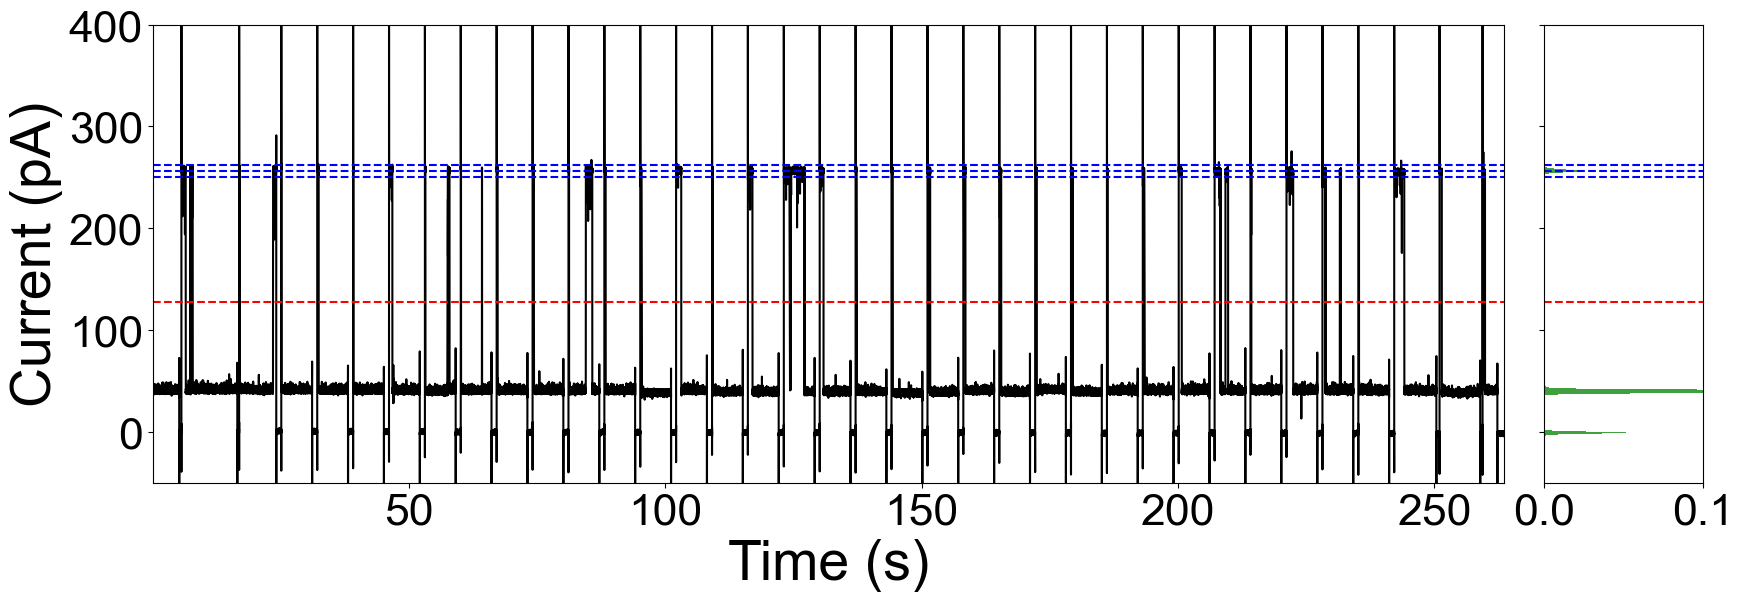

In [9]:
#pySNA.crop_trace(t_begin=341.)
pySNA.plot_temporal_and_hist(analyzed=False,ylim=[-50,400],color='g',hist_scale=0.1)

In [10]:
# Step 1: Find all points below the threshold
below = np.where((pySNA.data < pySNA.threshold) & (pySNA.data > 5e-12))[0]

# Step 2: Locate event start and end points
startandend = np.diff(below)
startpoints = np.insert(startandend, 0, 2)
endpoints = np.insert(startandend, -1, 2)

startpoints = np.where(startpoints > 1)[0]
endpoints = np.where(endpoints > 1)[0]

startpoints = below[startpoints]
endpoints = below[endpoints]

temp = endpoints-startpoints
startpoints = startpoints[temp > 2e3]
endpoints = endpoints[temp > 2e3]


endpoints = endpoints[ pySNA.data[startpoints-25] > pySNA.threshold ]
startpoints = startpoints[ pySNA.data[startpoints-25] > pySNA.threshold ]

In [11]:
from scipy.optimize import curve_fit

# 定义高斯函数用于拟合
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))
    
peak_position = []
peak_width = []
segment_median = []
segment_mean = []
segment_std = []
segment_dwell = []

for j in range(len(startpoints)):
    segment = pySNA.data[startpoints[j]+50:endpoints[j]-50]*1e12
    segment_median.append(np.median(segment)/pySNA.baseline/1e12)
    segment_std.append(np.std(segment))
    
    #if np.std(segment) > 10 :
    if np.median(segment)/pySNA.baseline/1e12 < 0.1 :
        plt.subplot(1,2,1)
        plt.plot(segment)
        plt.hlines(y=41,xmin=0,xmax=len(segment),colors='k',linestyles='--') #TTTT
        plt.ylim([0,150])    
        # 绘制包络线
        plt.subplot(1,2,2)
        hist, bins = np.histogram(segment, bins=451, density=True, range=(0, 150))
        bin_centers = (bins[:-1] + bins[1:]) / 2  # 计算每个 bin 的中心位置
        plt.plot(hist, bin_centers, alpha=0.7)
        plt.ylim([0,150])
        plt.title(f"# {j} : {np.std(segment):.2f}")
        plt.show()
        
startpoints = startpoints[(np.array(segment_median) > 0.1) & (np.array(segment_std) < 2.5)]
endpoints = endpoints[(np.array(segment_median) > 0.1) & (np.array(segment_std) < 2.5)]

pySNA.startpoints = startpoints
pySNA.endpoints = endpoints
print(len(startpoints))

peak_position = []
peak_width = []
segment_median = []
segment_mean = []
segment_std = []
segment_dwell = []

for j in range(len(startpoints)):
    #print(j)
    segment = pySNA.data[startpoints[j]+50:endpoints[j]-50]*1e12
    segment_dwell.append(((endpoints[j]-50) - (startpoints[j]+50))/1e4)
    segment_median.append(np.median(segment)/pySNA.baseline/1e12)
    segment_mean.append(np.mean(segment)/pySNA.baseline/1e12)
    segment_std.append(np.std(segment))
    
    # 拟合高斯函数
    try:
        hist, bins = np.histogram(segment, bins=451, density=True, range=(0, 150))
        bin_centers = (bins[:-1] + bins[1:]) / 2  # 计算每个 bin 的中心位置
        popt, _ = curve_fit(gaussian, bin_centers, hist, p0=[max(hist), bin_centers[np.argmax(hist)], 10])
        peak_position.append(popt[1])
        peak_width.append(popt[2] * 2.355)  # 半峰宽 = 2.355 * sigma
    except RuntimeError:
        print(f"Segment {j}: Gaussian fitting failed.")
        continue

42


(-50.0, 150.0)

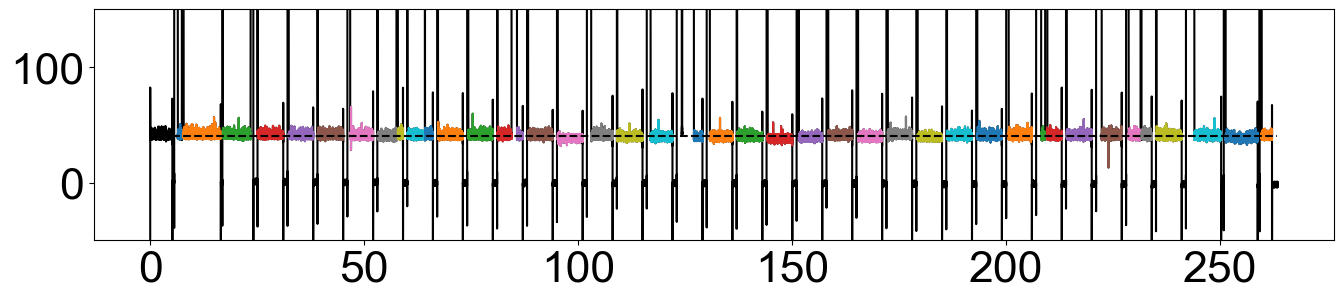

In [12]:
# 绘制直方图分布
plt.figure(figsize=(16, 3))

plt.plot(pySNA.t, pySNA.data*1e12, 'k')
for j in range(len(startpoints)):
    plt.plot(pySNA.t[startpoints[j]+50:endpoints[j]-50], pySNA.data[startpoints[j]+50:endpoints[j]-50]*1e12)

plt.hlines(y=0.1566*pySNA.baseline*1e12,xmin=0,xmax=np.max(pySNA.t),colors='k',linestyles='--') #TTTT

plt.ylim(-50,150)

(0.0, 10.0)

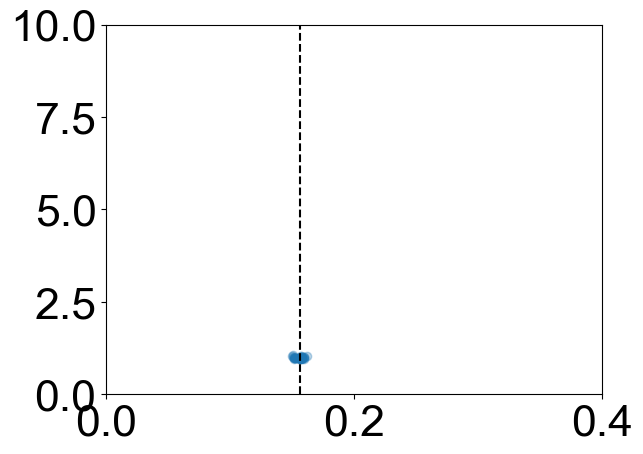

In [13]:
plt.scatter(segment_median,segment_std,alpha=0.3)
plt.plot([0.1566,0.1566],[0,10],'k--') #TTTT
plt.xlim(0,0.4)
plt.ylim(0,10)

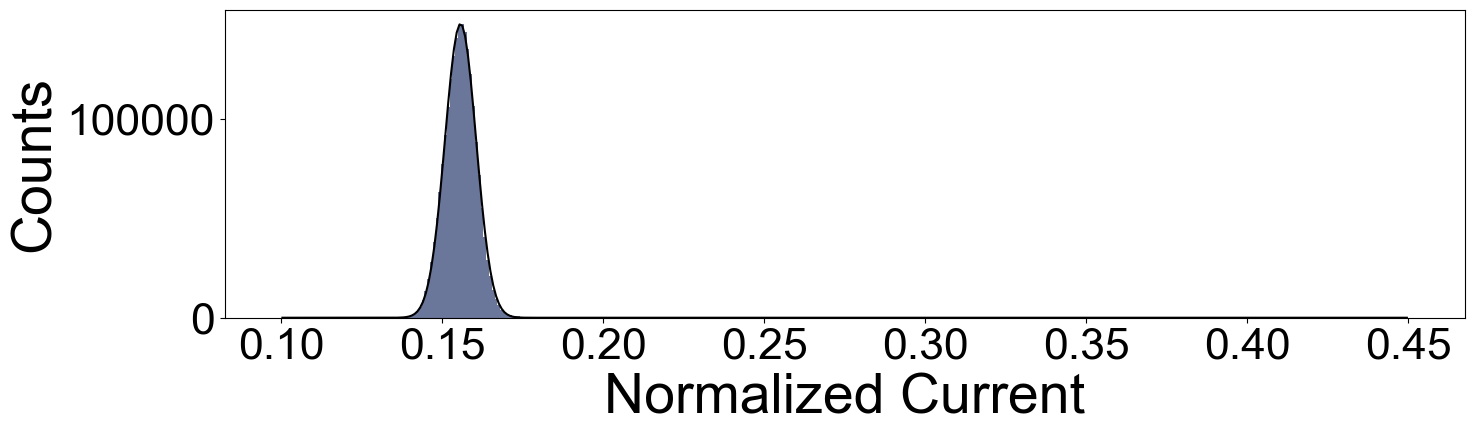

Peak 1: Amplitude = 1.48, Center = 0.1557, Sigma = 0.0048


In [14]:
# 定义通用的多高斯函数
def multi_gaussian(x, *params):
    """
    多高斯函数模型
    :param x: 自变量
    :param params: 参数列表，每三个参数代表一个高斯峰 (幅度、中心位置、标准差)
    :return: 多高斯函数的值
    """
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a, x0, sigma = params[i:i + 3]
        y += a * np.exp(-(x - x0)**2 / (2 * sigma**2))
    return y

# 动态生成初始参数猜测
def generate_initial_guess(num_peaks = 1, peak_centers = [0.5], peak_amp = [1.], peak_sigma = [0.01]):
    """
    根据指定的高斯峰数量生成初始参数猜测
    :param num_peaks: 高斯峰数量
    :param peak_centers: 直方图的 bin 中心位置
    :param peak_amp: 直方图的计数值
    :return: 初始参数列表
    """
    initial_guess = []
    peak_indices = np.linspace(0, len(peak_centers) - 1, num_peaks + 2)[1:-1].astype(int)
    for idx in peak_indices:
        amplitude = peak_amp[idx]
        center = peak_centers[idx]
        sigma = peak_sigma[idx]  # 默认标准差
        initial_guess.extend([amplitude, center, sigma])
    return initial_guess

fig = plt.figure(figsize=(16, 4))
counts, bins, patches = plt.hist(pySNA.data[2:][:-2]/pySNA.baseline,
                                 bins=401, 
                                 range=(0.1,0.45),
                                 color='#384879', alpha=0.75,
                                 linewidth=0.5,
                                 log=False)  # <<< 对数频次
# 计算 bin 中心位置
bin_centers = (bins[:-1] + bins[1:]) / 2
# 生成初始参数
num_peaks = 1
initial_guess = generate_initial_guess(num_peaks = num_peaks, peak_centers = [0.15,0.15,0.18,0.18], peak_amp = [3.0e5,2.0e5,0.05e5,0.8e5], peak_sigma = [1e-3,2e-3,2e-3,2e-3])
# 设置参数边界
# 幅度 > 0, 中心位置在 [0.05, 0.45], 标准差 > 0
lower_bounds = [0, 0.05, 0] * num_peaks  # 下界
upper_bounds = [2.5e5, 0.45, 5e-3] * num_peaks  # 上界 np.inf

# 拟合多高斯模型
try:
    popt, _ = curve_fit(multi_gaussian, bin_centers, counts, p0=initial_guess, bounds=(lower_bounds, upper_bounds))
    #print("Fitted Parameters:", popt)
except RuntimeError:
    print("Fitting failed. Please adjust the initial guess or data.")

# 绘制拟合结果
plt.plot(bin_centers, multi_gaussian(bin_centers, *popt), 'k-', label=f"{num_peaks}-Peak Gaussian Fit")
#plt.plot(bin_centers, 2.1e5 * np.exp(-(bin_centers - 0.1576)**2 / (2 * 4e-3**2)), 'r-')
#plt.plot(bin_centers, 0.08e5 * np.exp(-(bin_centers - 0.1817)**2 / (2 * 4e-3**2)), 'r-')
# 添加图例和标签
plt.xlabel("Normalized Current")
plt.ylabel("Counts")
plt.show()

# 输出拟合参数
for i in range(num_peaks):
    a, x0, sigma = popt[i * 3:(i + 1) * 3]
    print(f"Peak {i + 1}: Amplitude = {a/1e5:.2f}, Center = {x0:.4f}, Sigma = {sigma:.4f}")

np.savez("D10K+180mV.npz", counts=counts, bins=bins, segment_dwell=segment_dwell, segment_median=segment_median, segment_mean=segment_mean, segment_std=segment_std)

In [15]:
baseline = 214e-12 #加/减去offset之后的baseline
var = 2e-12
offset= -2e-12
threshold = baseline*0.5
pySNA = PySNA(baseline=baseline, var=var, threshold=threshold)
# 加载数据
pySNA.load(file_path2, output_samplerate=10000., lp_filter_cutoff=2500.)
pySNA.data = pySNA.data+offset

2026-02-17 03:20:51,820 - INFO - Successfully loaded .dat file: (K_buffer_D91N_160mV_9T_C_30T)20250814211615.dat
2026-02-17 03:20:51,863 - INFO - Data filtered with LP filter cutoff: 2500.0 Hz
2026-02-17 03:20:51,900 - INFO - Baseline = 33.26 pA, RMS = 90.54 pA


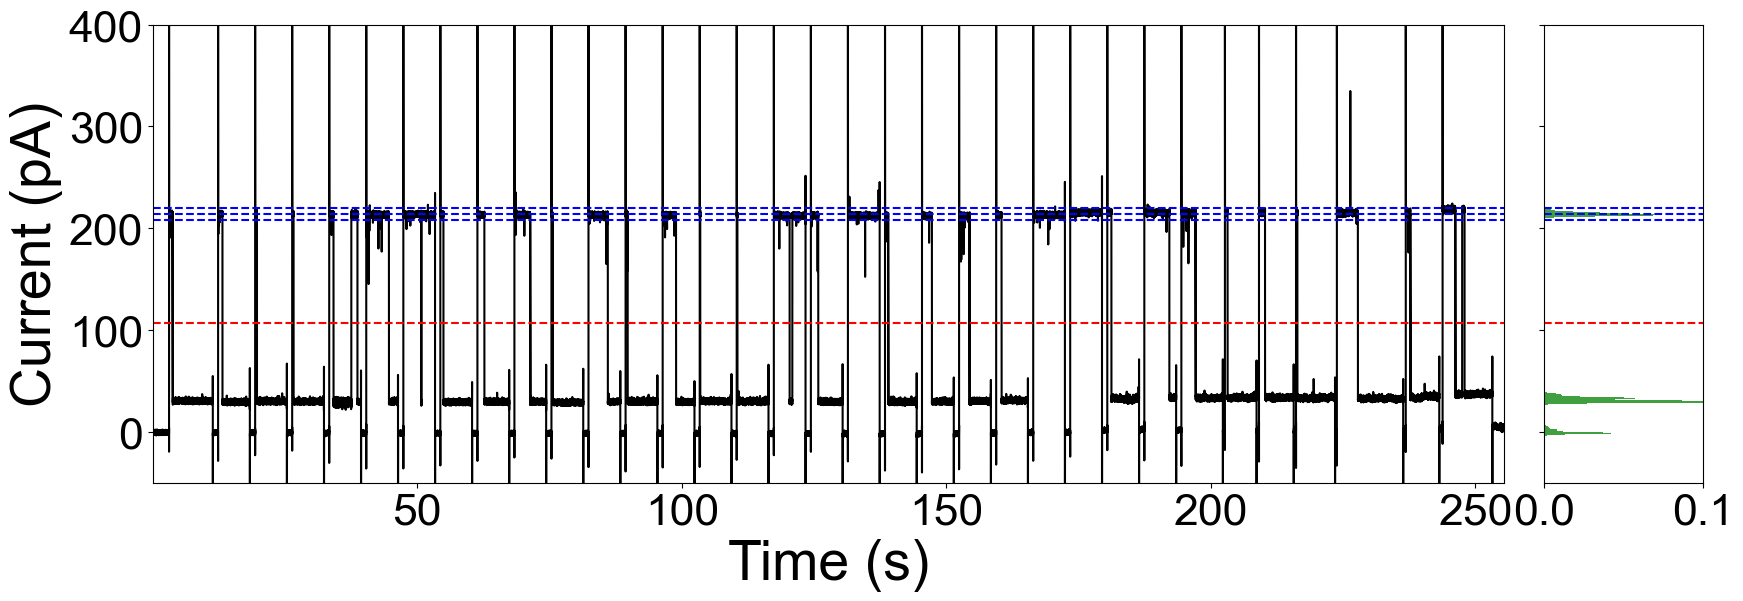

In [16]:
#pySNA.crop_trace(t_begin=341.)
pySNA.plot_temporal_and_hist(analyzed=False,ylim=[-50,400],color='g',hist_scale=0.1)

In [17]:
# Step 1: Find all points below the threshold
below = np.where((pySNA.data < pySNA.threshold) & (pySNA.data > 5e-12))[0]

# Step 2: Locate event start and end points
startandend = np.diff(below)
startpoints = np.insert(startandend, 0, 2)
endpoints = np.insert(startandend, -1, 2)

startpoints = np.where(startpoints > 1)[0]
endpoints = np.where(endpoints > 1)[0]

startpoints = below[startpoints]
endpoints = below[endpoints]

temp = endpoints-startpoints
startpoints = startpoints[temp > 2e3]
endpoints = endpoints[temp > 2e3]


endpoints = endpoints[ pySNA.data[startpoints-25] > pySNA.threshold ]
startpoints = startpoints[ pySNA.data[startpoints-25] > pySNA.threshold ]

In [18]:
from scipy.optimize import curve_fit

# 定义高斯函数用于拟合
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))
    
peak_position = []
peak_width = []
segment_median = []
segment_mean = []
segment_std = []
segment_dwell = []

for j in range(len(startpoints)):
    segment = pySNA.data[startpoints[j]+50:endpoints[j]-50]*1e12
    segment_median.append(np.median(segment)/pySNA.baseline/1e12)
    segment_std.append(np.std(segment))
    
    #if np.std(segment) > 10 :
    if np.median(segment)/pySNA.baseline/1e12 < 0.1 :
        plt.subplot(1,2,1)
        plt.plot(segment)
        plt.hlines(y=41,xmin=0,xmax=len(segment),colors='k',linestyles='--') #TTTT
        plt.ylim([0,150])    
        # 绘制包络线
        plt.subplot(1,2,2)
        hist, bins = np.histogram(segment, bins=451, density=True, range=(0, 150))
        bin_centers = (bins[:-1] + bins[1:]) / 2  # 计算每个 bin 的中心位置
        plt.plot(hist, bin_centers, alpha=0.7)
        plt.ylim([0,150])
        plt.title(f"# {j} : {np.std(segment):.2f}")
        plt.show()
        
startpoints = startpoints[(np.array(segment_median) > 0.1) & (np.array(segment_std) < 2.5)]
endpoints = endpoints[(np.array(segment_median) > 0.1) & (np.array(segment_std) < 2.5)]

pySNA.startpoints = startpoints
pySNA.endpoints = endpoints
print(len(startpoints))

peak_position = []
peak_width = []
segment_median = []
segment_mean = []
segment_std = []
segment_dwell = []

for j in range(len(startpoints)):
    #print(j)
    segment = pySNA.data[startpoints[j]+50:endpoints[j]-50]*1e12
    segment_dwell.append(((endpoints[j]-50) - (startpoints[j]+50))/1e4)
    segment_median.append(np.median(segment)/pySNA.baseline/1e12)
    segment_mean.append(np.mean(segment)/pySNA.baseline/1e12)
    segment_std.append(np.std(segment))
    
    # 拟合高斯函数
    try:
        hist, bins = np.histogram(segment, bins=451, density=True, range=(0, 150))
        bin_centers = (bins[:-1] + bins[1:]) / 2  # 计算每个 bin 的中心位置
        popt, _ = curve_fit(gaussian, bin_centers, hist, p0=[max(hist), bin_centers[np.argmax(hist)], 10])
        peak_position.append(popt[1])
        peak_width.append(popt[2] * 2.355)  # 半峰宽 = 2.355 * sigma
    except RuntimeError:
        print(f"Segment {j}: Gaussian fitting failed.")
        continue

32


(-50.0, 150.0)

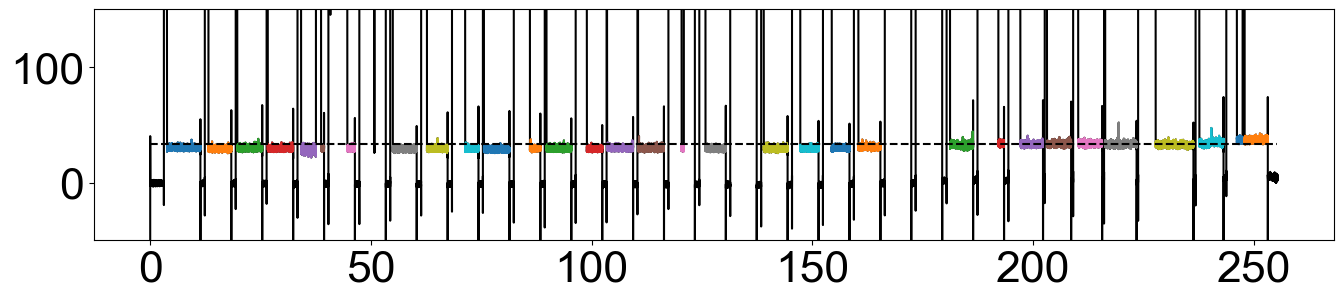

In [19]:
# 绘制直方图分布
plt.figure(figsize=(16, 3))

plt.plot(pySNA.t, pySNA.data*1e12, 'k')
for j in range(len(startpoints)):
    plt.plot(pySNA.t[startpoints[j]+50:endpoints[j]-50], pySNA.data[startpoints[j]+50:endpoints[j]-50]*1e12)

plt.hlines(y=0.1566*pySNA.baseline*1e12,xmin=0,xmax=np.max(pySNA.t),colors='k',linestyles='--') #TTTT

plt.ylim(-50,150)

(0.0, 10.0)

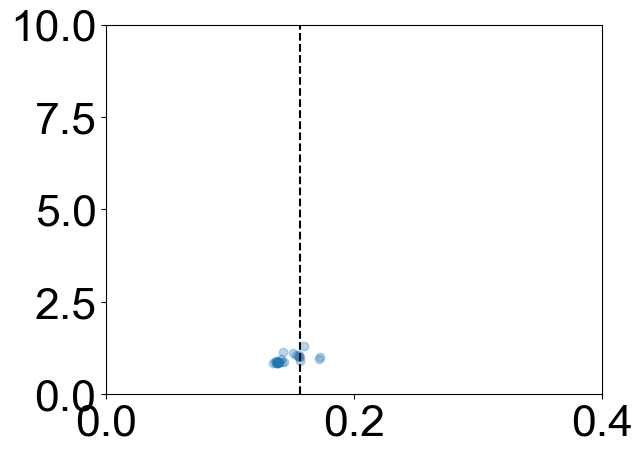

In [20]:
plt.scatter(segment_median,segment_std,alpha=0.3)
plt.plot([0.1566,0.1566],[0,10],'k--') #TTTT
plt.xlim(0,0.4)
plt.ylim(0,10)

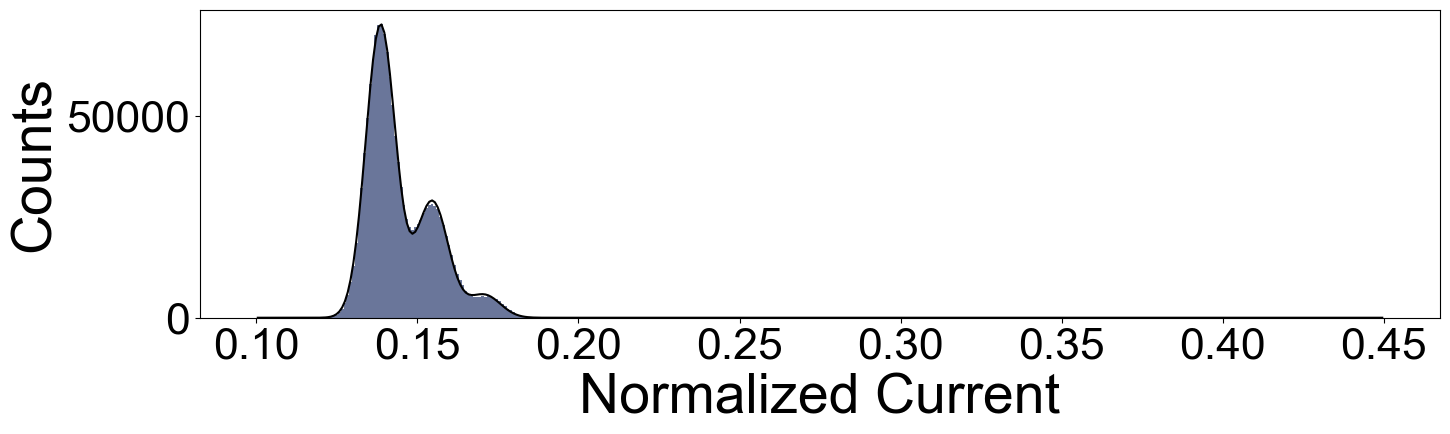

Peak 1: Amplitude = 0.73, Center = 0.1386, Sigma = 0.0046
Peak 2: Amplitude = 0.29, Center = 0.1546, Sigma = 0.0050
Peak 3: Amplitude = 0.06, Center = 0.1707, Sigma = 0.0050


In [21]:
# 定义通用的多高斯函数
def multi_gaussian(x, *params):
    """
    多高斯函数模型
    :param x: 自变量
    :param params: 参数列表，每三个参数代表一个高斯峰 (幅度、中心位置、标准差)
    :return: 多高斯函数的值
    """
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a, x0, sigma = params[i:i + 3]
        y += a * np.exp(-(x - x0)**2 / (2 * sigma**2))
    return y

# 动态生成初始参数猜测
def generate_initial_guess(num_peaks = 1, peak_centers = [0.5], peak_amp = [1.], peak_sigma = [0.01]):
    """
    根据指定的高斯峰数量生成初始参数猜测
    :param num_peaks: 高斯峰数量
    :param peak_centers: 直方图的 bin 中心位置
    :param peak_amp: 直方图的计数值
    :return: 初始参数列表
    """
    initial_guess = []
    peak_indices = np.linspace(0, len(peak_centers) - 1, num_peaks + 2)[1:-1].astype(int)
    for idx in peak_indices:
        amplitude = peak_amp[idx]
        center = peak_centers[idx]
        sigma = peak_sigma[idx]  # 默认标准差
        initial_guess.extend([amplitude, center, sigma])
    return initial_guess

fig = plt.figure(figsize=(16, 4))
counts, bins, patches = plt.hist(pySNA.data[2:][:-2]/pySNA.baseline,
                                 bins=401, 
                                 range=(0.1,0.45),
                                 color='#384879', alpha=0.75,
                                 linewidth=0.5,
                                 log=False)  # <<< 对数频次
# 计算 bin 中心位置
bin_centers = (bins[:-1] + bins[1:]) / 2
# 生成初始参数
num_peaks = 3
initial_guess = generate_initial_guess(num_peaks = num_peaks, peak_centers = [0.14,0.16,0.18,0.18], peak_amp = [1e5,5e4,5e4,0.8e5], peak_sigma = [1e-3,2e-3,2e-3,2e-3])
# 设置参数边界
# 幅度 > 0, 中心位置在 [0.05, 0.45], 标准差 > 0
lower_bounds = [0, 0.05, 0] * num_peaks  # 下界
upper_bounds = [2.5e5, 0.45, 5e-3] * num_peaks  # 上界 np.inf

# 拟合多高斯模型
try:
    popt, _ = curve_fit(multi_gaussian, bin_centers, counts, p0=initial_guess, bounds=(lower_bounds, upper_bounds))
    #print("Fitted Parameters:", popt)
except RuntimeError:
    print("Fitting failed. Please adjust the initial guess or data.")

# 绘制拟合结果
plt.plot(bin_centers, multi_gaussian(bin_centers, *popt), 'k-', label=f"{num_peaks}-Peak Gaussian Fit")
#plt.plot(bin_centers, 2.1e5 * np.exp(-(bin_centers - 0.1576)**2 / (2 * 4e-3**2)), 'r-')
#plt.plot(bin_centers, 0.08e5 * np.exp(-(bin_centers - 0.1817)**2 / (2 * 4e-3**2)), 'r-')
# 添加图例和标签
plt.xlabel("Normalized Current")
plt.ylabel("Counts")
plt.show()

# 输出拟合参数
for i in range(num_peaks):
    a, x0, sigma = popt[i * 3:(i + 1) * 3]
    print(f"Peak {i + 1}: Amplitude = {a/1e5:.2f}, Center = {x0:.4f}, Sigma = {sigma:.4f}")

np.savez("D10K+160mV.npz", counts=counts, bins=bins, segment_dwell=segment_dwell, segment_median=segment_median, segment_mean=segment_mean, segment_std=segment_std)

In [22]:
baseline = 177e-12 #加/减去offset之后的baseline
var = 2e-12
offset= -7e-12
threshold = baseline*0.5
pySNA = PySNA(baseline=baseline, var=var, threshold=threshold)
# 加载数据
pySNA.load(file_path3, output_samplerate=10000., lp_filter_cutoff=2500.)
pySNA.data = pySNA.data+offset

2026-02-17 03:20:55,165 - INFO - Successfully loaded .dat file: (K_buffer_D91N_140mV_9T_C_30T)20250814212030.dat
2026-02-17 03:20:55,206 - INFO - Data filtered with LP filter cutoff: 2500.0 Hz
2026-02-17 03:20:55,248 - INFO - Baseline = 181.69 pA, RMS = 78.28 pA


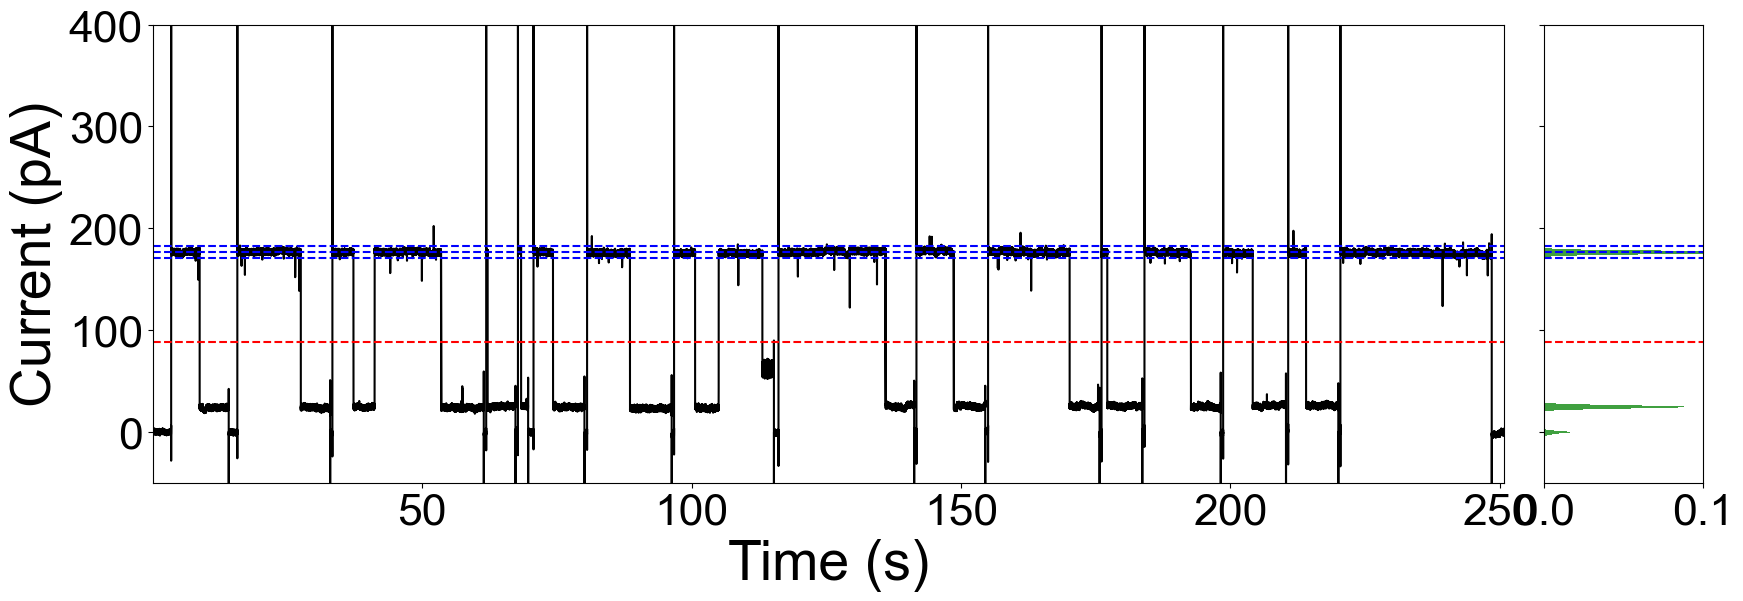

In [23]:
#pySNA.crop_trace(t_begin=341.)
pySNA.plot_temporal_and_hist(analyzed=False,ylim=[-50,400],color='g',hist_scale=0.1)

In [24]:
# Step 1: Find all points below the threshold
below = np.where((pySNA.data < pySNA.threshold) & (pySNA.data > 5e-12))[0]

# Step 2: Locate event start and end points
startandend = np.diff(below)
startpoints = np.insert(startandend, 0, 2)
endpoints = np.insert(startandend, -1, 2)

startpoints = np.where(startpoints > 1)[0]
endpoints = np.where(endpoints > 1)[0]

startpoints = below[startpoints]
endpoints = below[endpoints]

temp = endpoints-startpoints
startpoints = startpoints[temp > 2e3]
endpoints = endpoints[temp > 2e3]


endpoints = endpoints[ pySNA.data[startpoints-25] > pySNA.threshold ]
startpoints = startpoints[ pySNA.data[startpoints-25] > pySNA.threshold ]

In [25]:
from scipy.optimize import curve_fit

# 定义高斯函数用于拟合
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))
    
peak_position = []
peak_width = []
segment_median = []
segment_mean = []
segment_std = []
segment_dwell = []

for j in range(len(startpoints)):
    segment = pySNA.data[startpoints[j]+50:endpoints[j]-50]*1e12
    segment_median.append(np.median(segment)/pySNA.baseline/1e12)
    segment_std.append(np.std(segment))
    
    #if np.std(segment) > 10 :
    if np.median(segment)/pySNA.baseline/1e12 < 0.1 :
        plt.subplot(1,2,1)
        plt.plot(segment)
        plt.hlines(y=41,xmin=0,xmax=len(segment),colors='k',linestyles='--') #TTTT
        plt.ylim([0,150])    
        # 绘制包络线
        plt.subplot(1,2,2)
        hist, bins = np.histogram(segment, bins=451, density=True, range=(0, 150))
        bin_centers = (bins[:-1] + bins[1:]) / 2  # 计算每个 bin 的中心位置
        plt.plot(hist, bin_centers, alpha=0.7)
        plt.ylim([0,150])
        plt.title(f"# {j} : {np.std(segment):.2f}")
        plt.show()
        
startpoints = startpoints[(np.array(segment_median) > 0.1) & (np.array(segment_std) < 2.5)]
endpoints = endpoints[(np.array(segment_median) > 0.1) & (np.array(segment_std) < 2.5)]

pySNA.startpoints = startpoints
pySNA.endpoints = endpoints
print(len(startpoints))

peak_position = []
peak_width = []
segment_median = []
segment_mean = []
segment_std = []
segment_dwell = []

for j in range(len(startpoints)):
    #print(j)
    segment = pySNA.data[startpoints[j]+50:endpoints[j]-50]*1e12
    segment_dwell.append(((endpoints[j]-50) - (startpoints[j]+50))/1e4)
    segment_median.append(np.median(segment)/pySNA.baseline/1e12)
    segment_mean.append(np.mean(segment)/pySNA.baseline/1e12)
    segment_std.append(np.std(segment))
    
    # 拟合高斯函数
    try:
        hist, bins = np.histogram(segment, bins=451, density=True, range=(0, 150))
        bin_centers = (bins[:-1] + bins[1:]) / 2  # 计算每个 bin 的中心位置
        popt, _ = curve_fit(gaussian, bin_centers, hist, p0=[max(hist), bin_centers[np.argmax(hist)], 10])
        peak_position.append(popt[1])
        peak_width.append(popt[2] * 2.355)  # 半峰宽 = 2.355 * sigma
    except RuntimeError:
        print(f"Segment {j}: Gaussian fitting failed.")
        continue

16


(-50.0, 150.0)

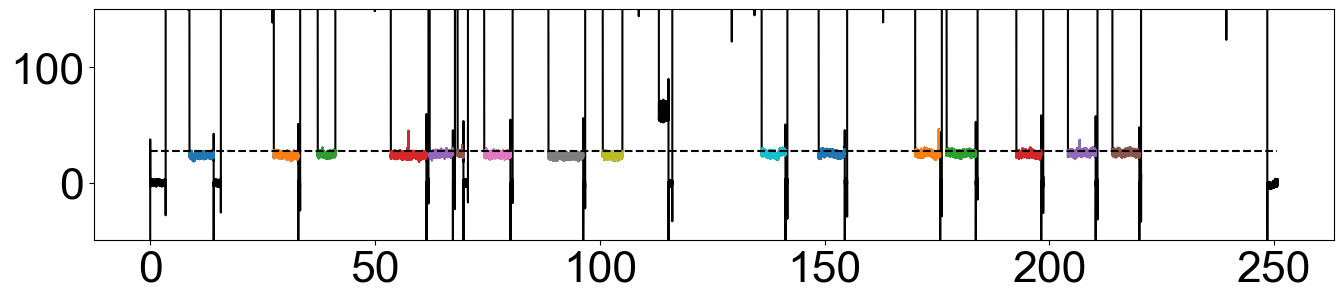

In [26]:
# 绘制直方图分布
plt.figure(figsize=(16, 3))

plt.plot(pySNA.t, pySNA.data*1e12, 'k')
for j in range(len(startpoints)):
    plt.plot(pySNA.t[startpoints[j]+50:endpoints[j]-50], pySNA.data[startpoints[j]+50:endpoints[j]-50]*1e12)

plt.hlines(y=0.1566*pySNA.baseline*1e12,xmin=0,xmax=np.max(pySNA.t),colors='k',linestyles='--') #TTTT

plt.ylim(-50,150)

(0.0, 10.0)

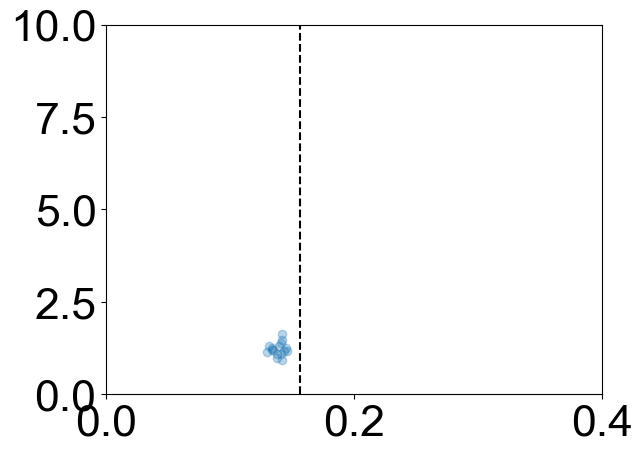

In [27]:
plt.scatter(segment_median,segment_std,alpha=0.3)
plt.plot([0.1566,0.1566],[0,10],'k--') #TTTT
plt.xlim(0,0.4)
plt.ylim(0,10)

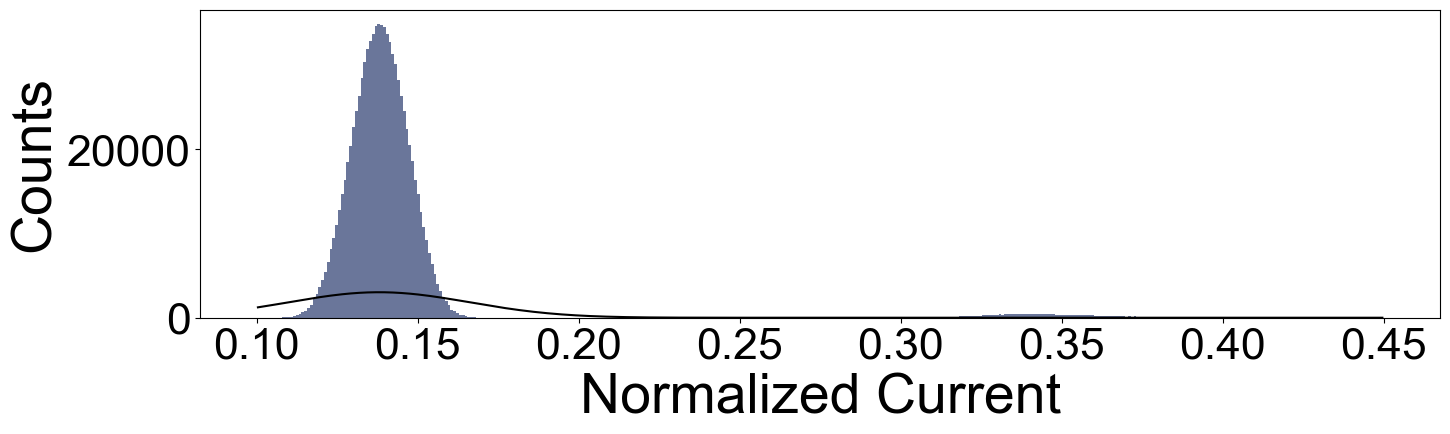

Peak 1: Amplitude = 0.03, Center = 0.1380, Sigma = 0.0281


In [28]:
# 定义通用的多高斯函数
def multi_gaussian(x, *params):
    """
    多高斯函数模型
    :param x: 自变量
    :param params: 参数列表，每三个参数代表一个高斯峰 (幅度、中心位置、标准差)
    :return: 多高斯函数的值
    """
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a, x0, sigma = params[i:i + 3]
        y += a * np.exp(-(x - x0)**2 / (2 * sigma**2))
    return y

# 动态生成初始参数猜测
def generate_initial_guess(num_peaks = 1, peak_centers = [0.5], peak_amp = [1.], peak_sigma = [0.01]):
    """
    根据指定的高斯峰数量生成初始参数猜测
    :param num_peaks: 高斯峰数量
    :param peak_centers: 直方图的 bin 中心位置
    :param peak_amp: 直方图的计数值
    :return: 初始参数列表
    """
    initial_guess = []
    peak_indices = np.linspace(0, len(peak_centers) - 1, num_peaks + 2)[1:-1].astype(int)
    for idx in peak_indices:
        amplitude = peak_amp[idx]
        center = peak_centers[idx]
        sigma = peak_sigma[idx]  # 默认标准差
        initial_guess.extend([amplitude, center, sigma])
    return initial_guess

fig = plt.figure(figsize=(16, 4))
counts, bins, patches = plt.hist(pySNA.data[2:][:-2]/pySNA.baseline,
                                 bins=401, 
                                 range=(0.1,0.45),
                                 color='#384879', alpha=0.75,
                                 linewidth=0.5,
                                 log=False)  # <<< 对数频次
# 计算 bin 中心位置
bin_centers = (bins[:-1] + bins[1:]) / 2
# 生成初始参数
num_peaks = 1
initial_guess = generate_initial_guess(num_peaks = num_peaks, peak_centers = [0.14,0.16,0.18,0.18], peak_amp = [1e5,5e4,5e4,0.8e5], peak_sigma = [5e-3,2e-3,2e-3,2e-3])
# 设置参数边界
# 幅度 > 0, 中心位置在 [0.05, 0.45], 标准差 > 0
lower_bounds = [0, 0.05, 0] * num_peaks  # 下界
upper_bounds = [np.inf, 0.45, np.inf] * num_peaks  # 上界 np.inf

# 拟合多高斯模型
try:
    popt, _ = curve_fit(multi_gaussian, bin_centers, counts, p0=initial_guess, bounds=(lower_bounds, upper_bounds))
    #print("Fitted Parameters:", popt)
except RuntimeError:
    print("Fitting failed. Please adjust the initial guess or data.")

# 绘制拟合结果
plt.plot(bin_centers, multi_gaussian(bin_centers, *popt), 'k-', label=f"{num_peaks}-Peak Gaussian Fit")
#plt.plot(bin_centers, 2.1e5 * np.exp(-(bin_centers - 0.1576)**2 / (2 * 4e-3**2)), 'r-')
#plt.plot(bin_centers, 0.08e5 * np.exp(-(bin_centers - 0.1817)**2 / (2 * 4e-3**2)), 'r-')
# 添加图例和标签
plt.xlabel("Normalized Current")
plt.ylabel("Counts")
plt.show()

# 输出拟合参数
for i in range(num_peaks):
    a, x0, sigma = popt[i * 3:(i + 1) * 3]
    print(f"Peak {i + 1}: Amplitude = {a/1e5:.2f}, Center = {x0:.4f}, Sigma = {sigma:.4f}")

np.savez("D10K+140mV.npz", counts=counts, bins=bins, segment_dwell=segment_dwell, segment_median=segment_median, segment_mean=segment_mean, segment_std=segment_std)

In [29]:
baseline = 137e-12 #加/减去offset之后的baseline
var = 2e-12
offset= 2e-12
threshold = baseline*0.5
pySNA = PySNA(baseline=baseline, var=var, threshold=threshold)
# 加载数据
pySNA.load(file_path4, output_samplerate=10000., lp_filter_cutoff=2500.)
pySNA.data = pySNA.data+offset

2026-02-17 03:20:58,407 - INFO - Successfully loaded .dat file: (K_buffer_D91N_120mV_9T_C_30T)20250814213905.dat
2026-02-17 03:20:58,453 - INFO - Data filtered with LP filter cutoff: 2500.0 Hz
2026-02-17 03:20:58,487 - INFO - Baseline = 133.32 pA, RMS = 58.18 pA


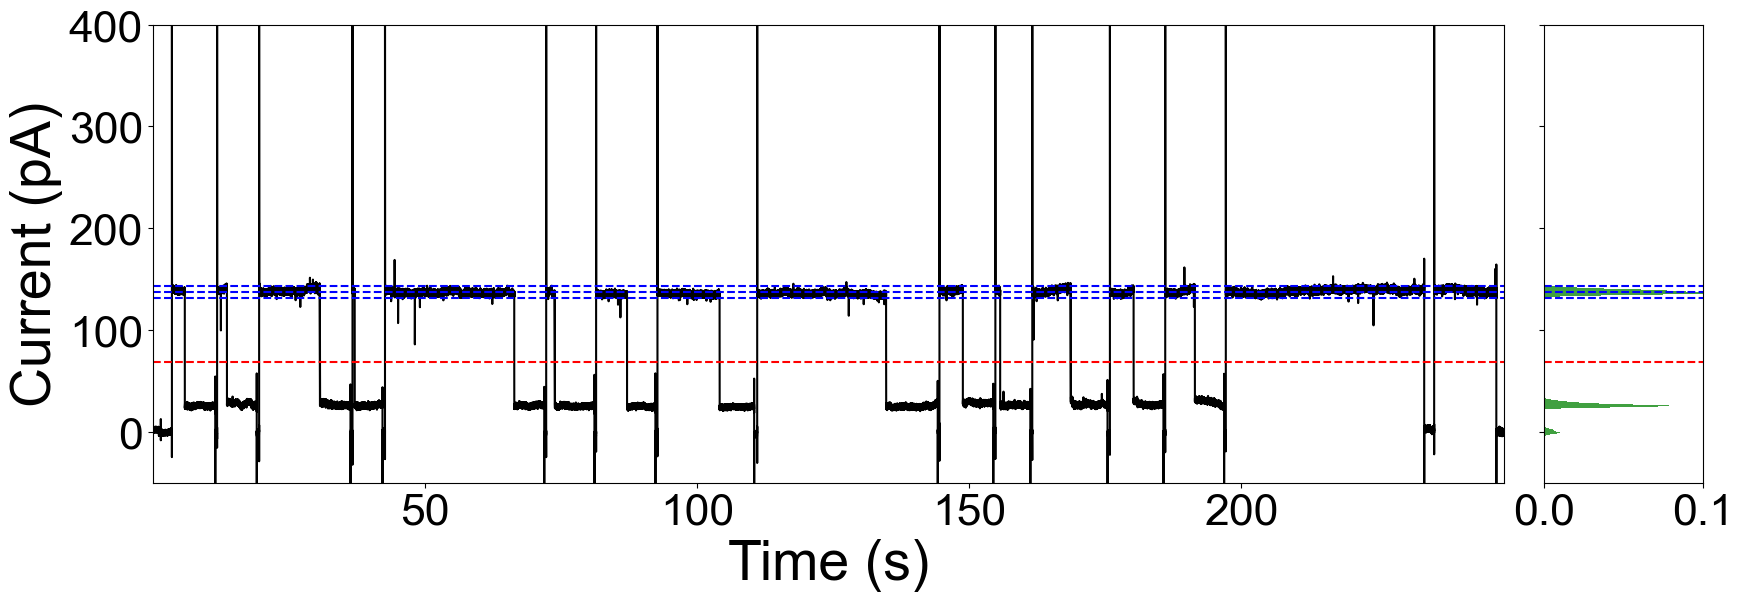

In [30]:
#pySNA.crop_trace(t_begin=341.)
pySNA.plot_temporal_and_hist(analyzed=False,ylim=[-50,400],color='g',hist_scale=0.1)

In [31]:
# Step 1: Find all points below the threshold
below = np.where((pySNA.data < pySNA.threshold) & (pySNA.data > 5e-12))[0]

# Step 2: Locate event start and end points
startandend = np.diff(below)
startpoints = np.insert(startandend, 0, 2)
endpoints = np.insert(startandend, -1, 2)

startpoints = np.where(startpoints > 1)[0]
endpoints = np.where(endpoints > 1)[0]

startpoints = below[startpoints]
endpoints = below[endpoints]

temp = endpoints-startpoints
startpoints = startpoints[temp > 2e3]
endpoints = endpoints[temp > 2e3]


endpoints = endpoints[ pySNA.data[startpoints-25] > pySNA.threshold ]
startpoints = startpoints[ pySNA.data[startpoints-25] > pySNA.threshold ]

In [32]:
from scipy.optimize import curve_fit

# 定义高斯函数用于拟合
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))
    
peak_position = []
peak_width = []
segment_median = []
segment_mean = []
segment_std = []
segment_dwell = []

for j in range(len(startpoints)):
    segment = pySNA.data[startpoints[j]+50:endpoints[j]-50]*1e12
    segment_median.append(np.median(segment)/pySNA.baseline/1e12)
    segment_std.append(np.std(segment))
    
    #if np.std(segment) > 10 :
    if np.median(segment)/pySNA.baseline/1e12 < 0.1 :
        plt.subplot(1,2,1)
        plt.plot(segment)
        plt.hlines(y=41,xmin=0,xmax=len(segment),colors='k',linestyles='--') #TTTT
        plt.ylim([0,150])    
        # 绘制包络线
        plt.subplot(1,2,2)
        hist, bins = np.histogram(segment, bins=451, density=True, range=(0, 150))
        bin_centers = (bins[:-1] + bins[1:]) / 2  # 计算每个 bin 的中心位置
        plt.plot(hist, bin_centers, alpha=0.7)
        plt.ylim([0,150])
        plt.title(f"# {j} : {np.std(segment):.2f}")
        plt.show()
        
startpoints = startpoints[(np.array(segment_median) > 0.1) & (np.array(segment_std) < 2.5)]
endpoints = endpoints[(np.array(segment_median) > 0.1) & (np.array(segment_std) < 2.5)]

pySNA.startpoints = startpoints
pySNA.endpoints = endpoints
print(len(startpoints))

peak_position = []
peak_width = []
segment_median = []
segment_mean = []
segment_std = []
segment_dwell = []

for j in range(len(startpoints)):
    #print(j)
    segment = pySNA.data[startpoints[j]+50:endpoints[j]-50]*1e12
    segment_dwell.append(((endpoints[j]-50) - (startpoints[j]+50))/1e4)
    segment_median.append(np.median(segment)/pySNA.baseline/1e12)
    segment_mean.append(np.mean(segment)/pySNA.baseline/1e12)
    segment_std.append(np.std(segment))
    
    # 拟合高斯函数
    try:
        hist, bins = np.histogram(segment, bins=451, density=True, range=(0, 150))
        bin_centers = (bins[:-1] + bins[1:]) / 2  # 计算每个 bin 的中心位置
        popt, _ = curve_fit(gaussian, bin_centers, hist, p0=[max(hist), bin_centers[np.argmax(hist)], 10])
        peak_position.append(popt[1])
        peak_width.append(popt[2] * 2.355)  # 半峰宽 = 2.355 * sigma
    except RuntimeError:
        print(f"Segment {j}: Gaussian fitting failed.")
        continue

14


(-50.0, 150.0)

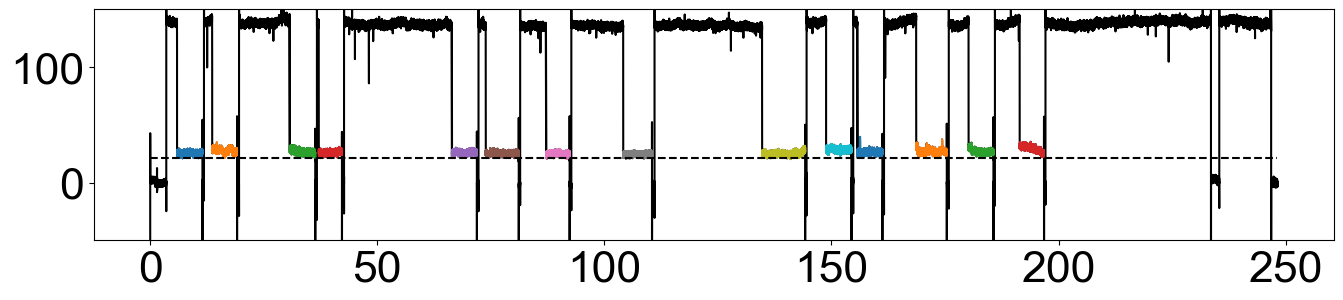

In [33]:
# 绘制直方图分布
plt.figure(figsize=(16, 3))

plt.plot(pySNA.t, pySNA.data*1e12, 'k')
for j in range(len(startpoints)):
    plt.plot(pySNA.t[startpoints[j]+50:endpoints[j]-50], pySNA.data[startpoints[j]+50:endpoints[j]-50]*1e12)

plt.hlines(y=0.1566*pySNA.baseline*1e12,xmin=0,xmax=np.max(pySNA.t),colors='k',linestyles='--') #TTTT

plt.ylim(-50,150)

(0.0, 10.0)

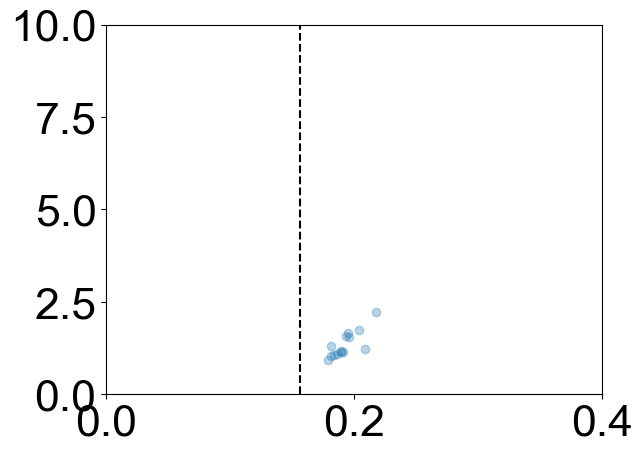

In [34]:
plt.scatter(segment_median,segment_std,alpha=0.3)
plt.plot([0.1566,0.1566],[0,10],'k--') #TTTT
plt.xlim(0,0.4)
plt.ylim(0,10)

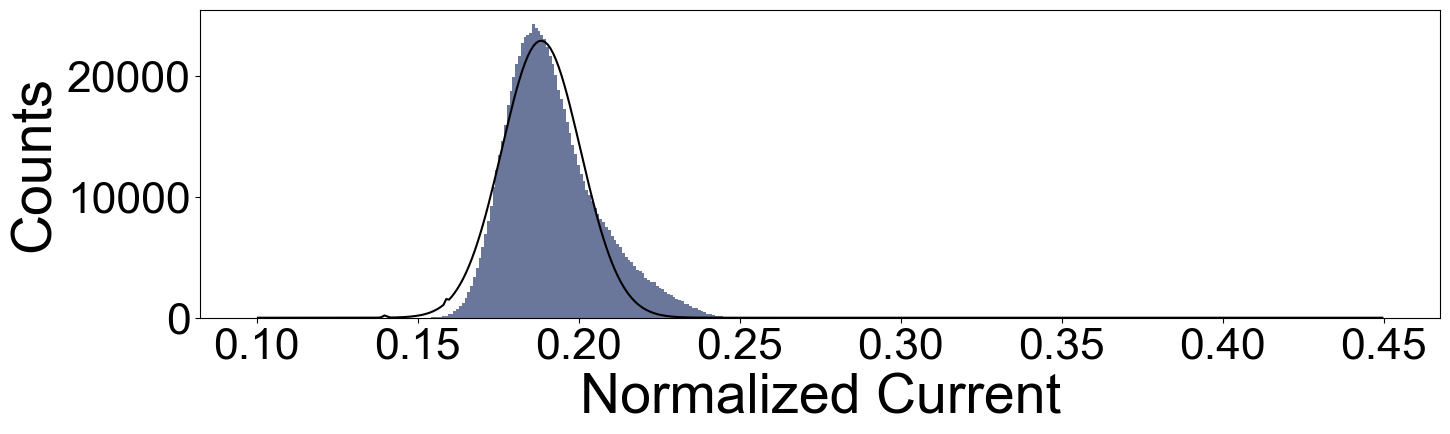

Peak 1: Amplitude = 0.00, Center = 0.1399, Sigma = 0.0006
Peak 2: Amplitude = 0.01, Center = 0.1592, Sigma = 0.0002
Peak 3: Amplitude = 0.23, Center = 0.1884, Sigma = 0.0122


In [35]:
# 定义通用的多高斯函数
def multi_gaussian(x, *params):
    """
    多高斯函数模型
    :param x: 自变量
    :param params: 参数列表，每三个参数代表一个高斯峰 (幅度、中心位置、标准差)
    :return: 多高斯函数的值
    """
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a, x0, sigma = params[i:i + 3]
        y += a * np.exp(-(x - x0)**2 / (2 * sigma**2))
    return y

# 动态生成初始参数猜测
def generate_initial_guess(num_peaks = 1, peak_centers = [0.5], peak_amp = [1.], peak_sigma = [0.01]):
    """
    根据指定的高斯峰数量生成初始参数猜测
    :param num_peaks: 高斯峰数量
    :param peak_centers: 直方图的 bin 中心位置
    :param peak_amp: 直方图的计数值
    :return: 初始参数列表
    """
    initial_guess = []
    peak_indices = np.linspace(0, len(peak_centers) - 1, num_peaks + 2)[1:-1].astype(int)
    for idx in peak_indices:
        amplitude = peak_amp[idx]
        center = peak_centers[idx]
        sigma = peak_sigma[idx]  # 默认标准差
        initial_guess.extend([amplitude, center, sigma])
    return initial_guess

fig = plt.figure(figsize=(16, 4))
counts, bins, patches = plt.hist(pySNA.data[2:][:-2]/pySNA.baseline,
                                 bins=401, 
                                 range=(0.1,0.45),
                                 color='#384879', alpha=0.75,
                                 linewidth=0.5,
                                 log=False)  # <<< 对数频次
# 计算 bin 中心位置
bin_centers = (bins[:-1] + bins[1:]) / 2

# 生成初始参数
num_peaks = 3
initial_guess = generate_initial_guess(num_peaks = num_peaks, peak_centers = [0.14,0.16,0.18,0.18], peak_amp = [2e4,5e4,5e4,0.8e5], peak_sigma = [5e-3,2e-3,2e-3,2e-3])
# 设置参数边界
# 幅度 > 0, 中心位置在 [0.05, 0.45], 标准差 > 0
lower_bounds = [0, 0.05, 0] * num_peaks  # 下界
upper_bounds = [np.inf, 0.45, np.inf] * num_peaks  # 上界 np.inf

# 拟合多高斯模型
try:
    popt, _ = curve_fit(multi_gaussian, bin_centers, counts, p0=initial_guess, bounds=(lower_bounds, upper_bounds))
    #print("Fitted Parameters:", popt)
except RuntimeError:
    print("Fitting failed. Please adjust the initial guess or data.")

# 绘制拟合结果
plt.plot(bin_centers, multi_gaussian(bin_centers, *popt), 'k-', label=f"{num_peaks}-Peak Gaussian Fit")
#plt.plot(bin_centers, 2.1e5 * np.exp(-(bin_centers - 0.1576)**2 / (2 * 4e-3**2)), 'r-')
#plt.plot(bin_centers, 0.08e5 * np.exp(-(bin_centers - 0.1817)**2 / (2 * 4e-3**2)), 'r-')
# 添加图例和标签
plt.xlabel("Normalized Current")
plt.ylabel("Counts")
plt.show()

# 输出拟合参数
for i in range(num_peaks):
    a, x0, sigma = popt[i * 3:(i + 1) * 3]
    print(f"Peak {i + 1}: Amplitude = {a/1e5:.2f}, Center = {x0:.4f}, Sigma = {sigma:.4f}")

np.savez("D10K+120mV.npz", counts=counts, bins=bins, segment_dwell=segment_dwell, segment_median=segment_median, segment_mean=segment_mean, segment_std=segment_std)

In [36]:
baseline = 120e-12 #加/减去offset之后的baseline
var = 2e-12
offset= -2e-12
threshold = baseline*0.5
pySNA = PySNA(baseline=baseline, var=var, threshold=threshold)
# 加载数据
pySNA.load(file_path5, output_samplerate=10000., lp_filter_cutoff=2500.)
pySNA.data = pySNA.data+offset

2026-02-17 03:21:01,888 - INFO - Successfully loaded .dat file: (K_buffer_D91N_100mV_9T_C_30T)20250814213311.dat
2026-02-17 03:21:01,948 - INFO - Data filtered with LP filter cutoff: 2500.0 Hz
2026-02-17 03:21:01,999 - INFO - Baseline = 115.01 pA, RMS = 38.41 pA


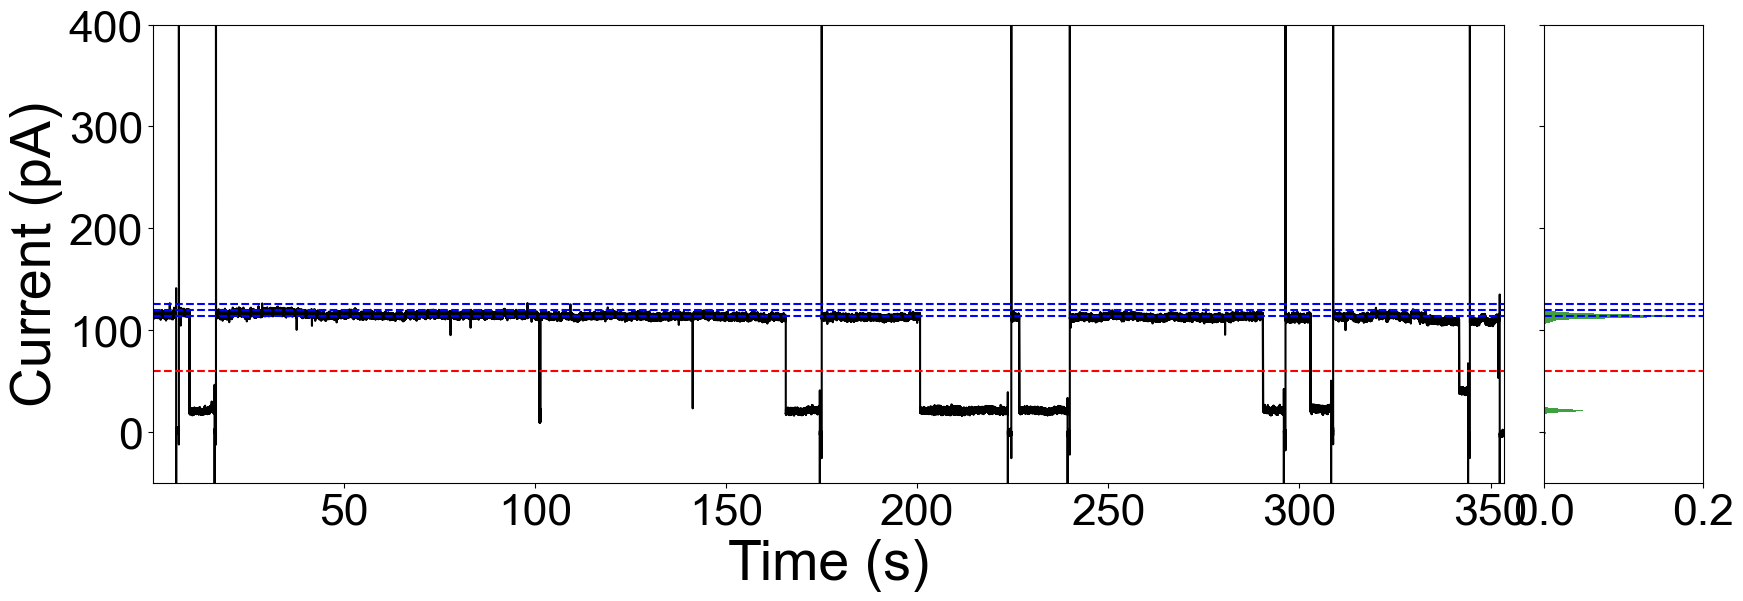

In [37]:
#pySNA.crop_trace(t_begin=341.)
pySNA.plot_temporal_and_hist(analyzed=False,ylim=[-50,400],color='g',hist_scale=0.2)

In [38]:
# Step 1: Find all points below the threshold
below = np.where((pySNA.data < pySNA.threshold) & (pySNA.data > 5e-12))[0]

# Step 2: Locate event start and end points
startandend = np.diff(below)
startpoints = np.insert(startandend, 0, 2)
endpoints = np.insert(startandend, -1, 2)

startpoints = np.where(startpoints > 1)[0]
endpoints = np.where(endpoints > 1)[0]

startpoints = below[startpoints]
endpoints = below[endpoints]

temp = endpoints-startpoints
startpoints = startpoints[temp > 2e3]
endpoints = endpoints[temp > 2e3]


endpoints = endpoints[ pySNA.data[startpoints-25] > pySNA.threshold ]
startpoints = startpoints[ pySNA.data[startpoints-25] > pySNA.threshold ]

In [39]:
from scipy.optimize import curve_fit

# 定义高斯函数用于拟合
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))
    
peak_position = []
peak_width = []
segment_median = []
segment_mean = []
segment_std = []
segment_dwell = []

for j in range(len(startpoints)):
    segment = pySNA.data[startpoints[j]+50:endpoints[j]-50]*1e12
    segment_median.append(np.median(segment)/pySNA.baseline/1e12)
    segment_std.append(np.std(segment))
    
    #if np.std(segment) > 10 :
    if np.median(segment)/pySNA.baseline/1e12 < 0.1 :
        plt.subplot(1,2,1)
        plt.plot(segment)
        plt.hlines(y=41,xmin=0,xmax=len(segment),colors='k',linestyles='--') #TTTT
        plt.ylim([0,150])    
        # 绘制包络线
        plt.subplot(1,2,2)
        hist, bins = np.histogram(segment, bins=451, density=True, range=(0, 150))
        bin_centers = (bins[:-1] + bins[1:]) / 2  # 计算每个 bin 的中心位置
        plt.plot(hist, bin_centers, alpha=0.7)
        plt.ylim([0,150])
        plt.title(f"# {j} : {np.std(segment):.2f}")
        plt.show()
        
startpoints = startpoints[(np.array(segment_median) > 0.1) & (np.array(segment_std) < 2.5)]
endpoints = endpoints[(np.array(segment_median) > 0.1) & (np.array(segment_std) < 2.5)]

pySNA.startpoints = startpoints
pySNA.endpoints = endpoints
print(len(startpoints))

peak_position = []
peak_width = []
segment_median = []
segment_mean = []
segment_std = []
segment_dwell = []

for j in range(len(startpoints)):
    #print(j)
    segment = pySNA.data[startpoints[j]+50:endpoints[j]-50]*1e12
    segment_dwell.append(((endpoints[j]-50) - (startpoints[j]+50))/1e4)
    segment_median.append(np.median(segment)/pySNA.baseline/1e12)
    segment_mean.append(np.mean(segment)/pySNA.baseline/1e12)
    segment_std.append(np.std(segment))
    
    # 拟合高斯函数
    try:
        hist, bins = np.histogram(segment, bins=451, density=True, range=(0, 150))
        bin_centers = (bins[:-1] + bins[1:]) / 2  # 计算每个 bin 的中心位置
        popt, _ = curve_fit(gaussian, bin_centers, hist, p0=[max(hist), bin_centers[np.argmax(hist)], 10])
        peak_position.append(popt[1])
        peak_width.append(popt[2] * 2.355)  # 半峰宽 = 2.355 * sigma
    except RuntimeError:
        print(f"Segment {j}: Gaussian fitting failed.")
        continue

8


(-50.0, 150.0)

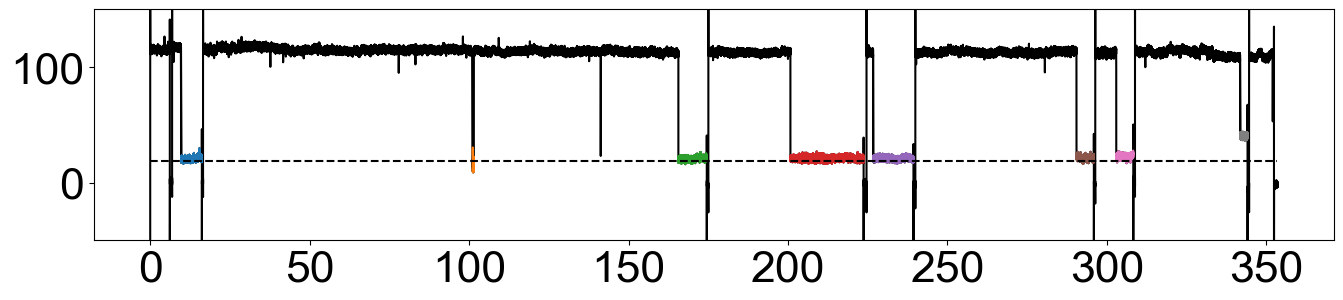

In [40]:
# 绘制直方图分布
plt.figure(figsize=(16, 3))

plt.plot(pySNA.t, pySNA.data*1e12, 'k')
for j in range(len(startpoints)):
    plt.plot(pySNA.t[startpoints[j]+50:endpoints[j]-50], pySNA.data[startpoints[j]+50:endpoints[j]-50]*1e12)

plt.hlines(y=0.1566*pySNA.baseline*1e12,xmin=0,xmax=np.max(pySNA.t),colors='k',linestyles='--') #TTTT

plt.ylim(-50,150)

(0.0, 10.0)

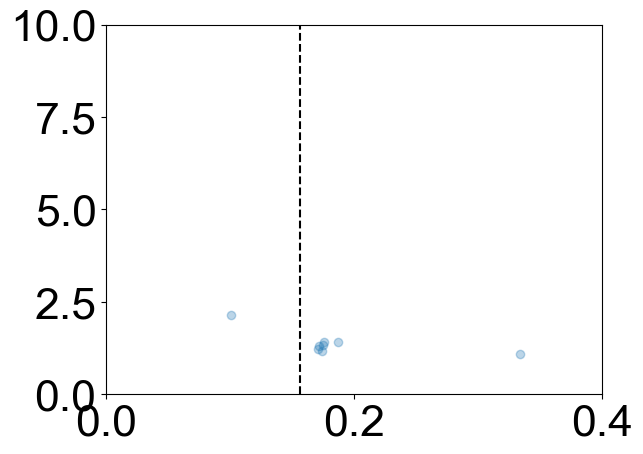

In [41]:
plt.scatter(segment_median,segment_std,alpha=0.3)
plt.plot([0.1566,0.1566],[0,10],'k--') #TTTT
plt.xlim(0,0.4)
plt.ylim(0,10)

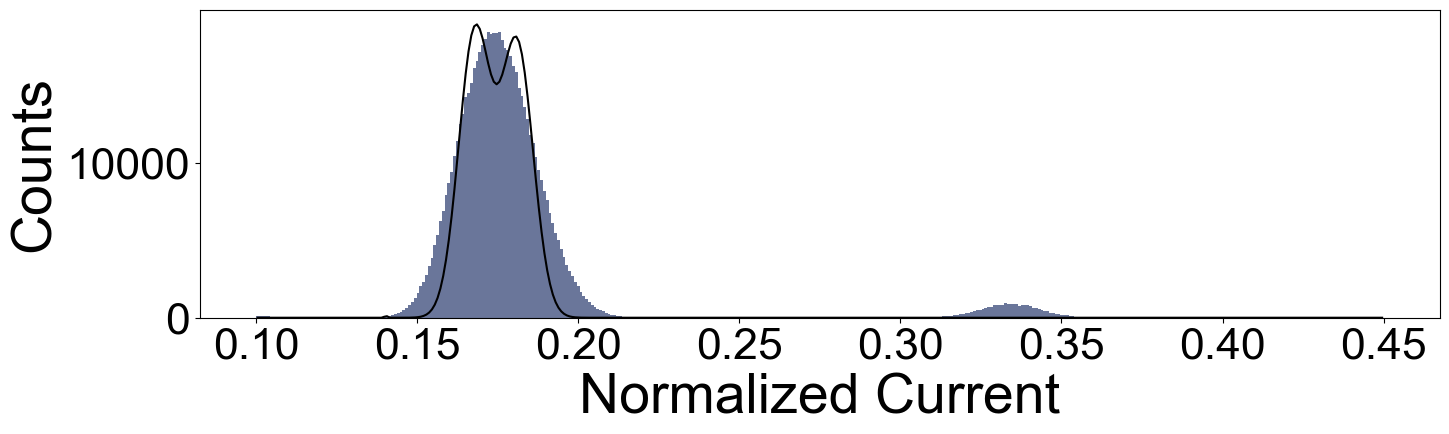

Peak 1: Amplitude = 0.06, Center = 0.1402, Sigma = 0.0001
Peak 2: Amplitude = 0.18, Center = 0.1678, Sigma = 0.0050
Peak 3: Amplitude = 0.18, Center = 0.1810, Sigma = 0.0050


In [42]:
# 定义通用的多高斯函数
def multi_gaussian(x, *params):
    """
    多高斯函数模型
    :param x: 自变量
    :param params: 参数列表，每三个参数代表一个高斯峰 (幅度、中心位置、标准差)
    :return: 多高斯函数的值
    """
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a, x0, sigma = params[i:i + 3]
        y += a * np.exp(-(x - x0)**2 / (2 * sigma**2))
    return y

# 动态生成初始参数猜测
def generate_initial_guess(num_peaks = 1, peak_centers = [0.5], peak_amp = [1.], peak_sigma = [0.01]):
    """
    根据指定的高斯峰数量生成初始参数猜测
    :param num_peaks: 高斯峰数量
    :param peak_centers: 直方图的 bin 中心位置
    :param peak_amp: 直方图的计数值
    :return: 初始参数列表
    """
    initial_guess = []
    peak_indices = np.linspace(0, len(peak_centers) - 1, num_peaks + 2)[1:-1].astype(int)
    for idx in peak_indices:
        amplitude = peak_amp[idx]
        center = peak_centers[idx]
        sigma = peak_sigma[idx]  # 默认标准差
        initial_guess.extend([amplitude, center, sigma])
    return initial_guess

fig = plt.figure(figsize=(16, 4))
counts, bins, patches = plt.hist(pySNA.data[2:][:-2]/pySNA.baseline,
                                 bins=401, 
                                 range=(0.1,0.45),
                                 color='#384879', alpha=0.75,
                                 linewidth=0.5,
                                 log=False)  # <<< 对数频次
# 计算 bin 中心位置
bin_centers = (bins[:-1] + bins[1:]) / 2
# 生成初始参数
num_peaks = 3
initial_guess = generate_initial_guess(num_peaks = num_peaks, peak_centers = [0.14,0.16,0.18,0.18], peak_amp = [1e5,5e4,5e4,0.8e5], peak_sigma = [1e-3,2e-3,2e-3,2e-3])
# 设置参数边界
# 幅度 > 0, 中心位置在 [0.05, 0.45], 标准差 > 0
lower_bounds = [0, 0.05, 0] * num_peaks  # 下界
upper_bounds = [2.5e5, 0.45, 5e-3] * num_peaks  # 上界 np.inf

# 拟合多高斯模型
try:
    popt, _ = curve_fit(multi_gaussian, bin_centers, counts, p0=initial_guess, bounds=(lower_bounds, upper_bounds))
    #print("Fitted Parameters:", popt)
except RuntimeError:
    print("Fitting failed. Please adjust the initial guess or data.")

# 绘制拟合结果
plt.plot(bin_centers, multi_gaussian(bin_centers, *popt), 'k-', label=f"{num_peaks}-Peak Gaussian Fit")
#plt.plot(bin_centers, 2.1e5 * np.exp(-(bin_centers - 0.1576)**2 / (2 * 4e-3**2)), 'r-')
#plt.plot(bin_centers, 0.08e5 * np.exp(-(bin_centers - 0.1817)**2 / (2 * 4e-3**2)), 'r-')
# 添加图例和标签
plt.xlabel("Normalized Current")
plt.ylabel("Counts")
plt.show()

# 输出拟合参数
for i in range(num_peaks):
    a, x0, sigma = popt[i * 3:(i + 1) * 3]
    print(f"Peak {i + 1}: Amplitude = {a/1e5:.2f}, Center = {x0:.4f}, Sigma = {sigma:.4f}")

np.savez("D10K+100mV.npz", counts=counts, bins=bins, segment_dwell=segment_dwell, segment_median=segment_median, segment_mean=segment_mean, segment_std=segment_std)